In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Load users data
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Add days from creation to last login feature
users_df.last_session_creation_time = pd.to_datetime(users_df.last_session_creation_time, unit='s')
users_df.creation_time = pd.to_datetime(users_df.creation_time)
users_df['days_since_signup'] = (users_df.last_session_creation_time - users_df.creation_time).apply(lambda x: x.days)

In [4]:
# Extract domain from email address
users_df.email = users_df.email.apply(lambda x: x.split('@')[1].split('.')[0])

In [5]:
invite_times = pd.DataFrame(users_df.invited_by_user_id.value_counts()).reset_index()
invite_times.columns = ['id', 'invite_times']
users_df = users_df.merge(invite_times, left_on='object_id', right_on='id', how='outer')
users_df.invite_times.fillna(0, inplace=True)

In [6]:
users_df.drop(['creation_time', 'name', 'last_session_creation_time', 'invited_by_user_id', 'id'], axis=1, inplace=True)

In [7]:
# Fill null values with 0
users_df.days_since_signup.fillna(0, inplace=True)
users_df.opted_in_to_mailing_list.fillna(0, inplace=True)
users_df.enabled_for_marketing_drip.fillna(0, inplace=True)

In [8]:
# Load engagement data
engagement_df = pd.read_csv('takehome_user_engagement.csv')
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
# Generate target variable
engagement_df.time_stamp = pd.to_datetime(engagement_df['time_stamp'])
user_id = engagement_df.user_id.unique()

adoption_list = []
for i in user_id:
    df = engagement_df[engagement_df.user_id == i].reset_index().sort_values(by='time_stamp')
    status = False
    if len(df) < 3:
        pass
    else: 
        for j in range(0, len(df)-2): 
            time_diff = df.time_stamp[j+2] - df.time_stamp[j]
            date1 = df.time_stamp[j].date()
            date2 = df.time_stamp[j+1].date()
            date3 = df.time_stamp[j+2].date()
            if (time_diff < pd.Timedelta('7 days')) & (date1 != date2) & (date2 != date3):
                status = True
            else:
                pass
    adoption_list.append(status)   

adoption_users = pd.DataFrame({'user_id': user_id, 'adopted': adoption_list})
adoption_users.head()

,adopted,user_id
0,False,1
1,True,2
2,False,3
3,False,4
4,False,5


In [10]:
print(len(users_df.object_id.unique()), len(user_id))

12000 8823


In [11]:
df = users_df.merge(adoption_users, left_on='object_id', right_on='user_id', how='outer')
df.adopted.fillna(False, inplace=True)
df.drop(['user_id', 'object_id'], axis=1, inplace=True)
df.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,days_since_signup,invite_times,adopted
0,yahoo,GUEST_INVITE,1,0,11,0.0,0.0,False
1,gustr,ORG_INVITE,0,0,1,136.0,0.0,True
2,gustr,ORG_INVITE,0,0,94,0.0,1.0,False
3,yahoo,GUEST_INVITE,0,0,1,1.0,0.0,False
4,yahoo,GUEST_INVITE,0,0,193,5.0,0.0,False


In [12]:
df.email.value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
mumdc            2
rerwl            2
luque            2
xybhi            2
Name: email, dtype: int64

In [13]:
# Regroup small size email domains as one group 'other'
pd.options.mode.chained_assignment = None
main_domain = ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']
df.email[~df.email.isin(main_domain)] = 'others'

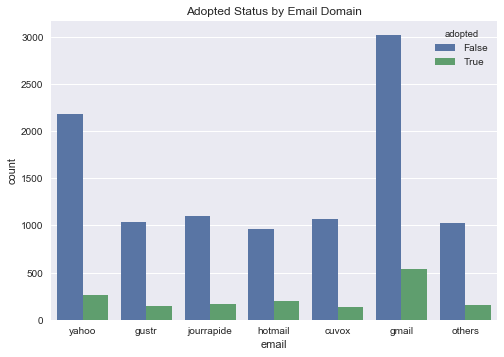

In [14]:
sns.countplot(x='email', hue='adopted', data=df)
plt.title('Adopted Status by Email Domain')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

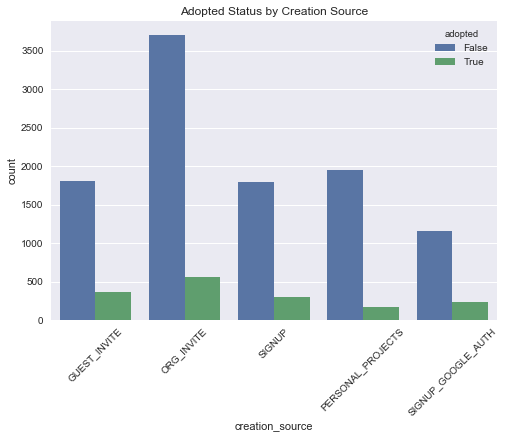

In [15]:
sns.countplot(x='creation_source', hue='adopted', data=df)
plt.title('Adopted Status by Creation Source')
plt.xticks(rotation=45)

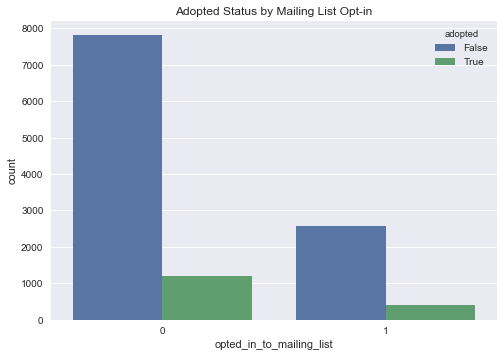

In [16]:
sns.countplot(x='opted_in_to_mailing_list', hue='adopted', data=df)
plt.title('Adopted Status by Mailing List Opt-in')

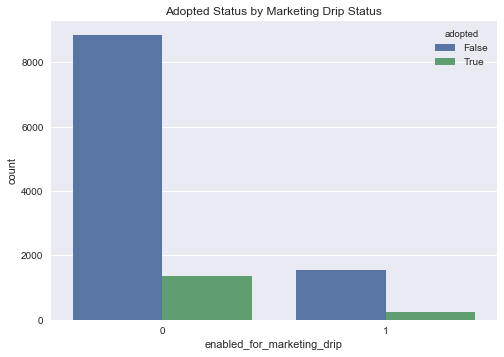

In [17]:
sns.countplot(x='enabled_for_marketing_drip', hue='adopted', data=df)
plt.title('Adopted Status by Marketing Drip Status')

In [18]:
df.org_id.value_counts().head(10)

0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: org_id, dtype: int64

In [19]:
# Regroup org_id as whether the org_id belongs to top 10 large population organization
main_org = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
df.org_id[df.org_id.isin(main_org)] = 'major'
df.org_id[df.org_id != 'major'] = 'minor'

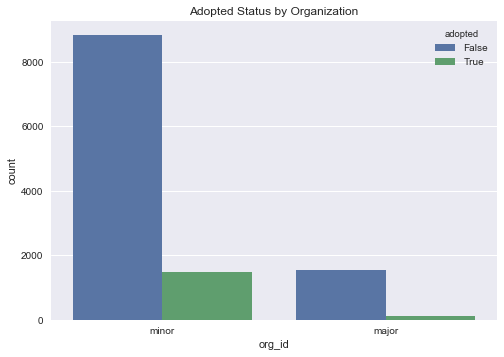

In [20]:
sns.countplot(x='org_id', hue='adopted', data=df)
plt.title('Adopted Status by Organization')

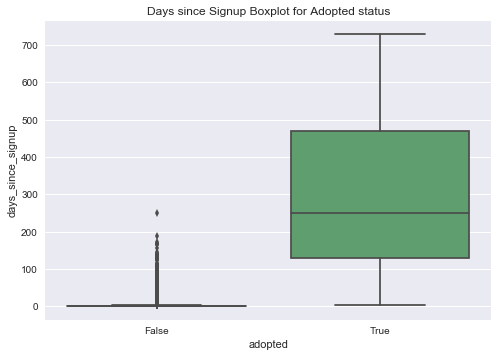

In [21]:
plt.title('Days since Signup Boxplot for Adopted status')
sns.boxplot(y='days_since_signup', x='adopted', data=df)

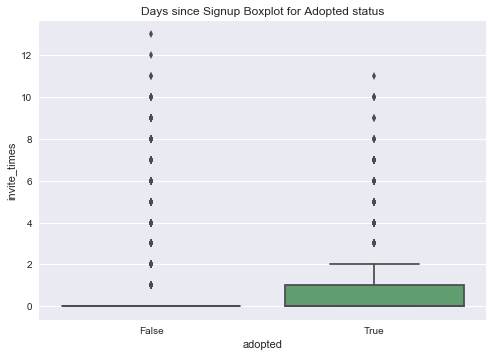

In [22]:
sns.boxplot(y='invite_times', x='adopted', data=df)
plt.title('Days since Signup Boxplot for Adopted status')

In [23]:
email = pd.get_dummies(df.email, drop_first=True)
creation_source = pd.get_dummies(df.creation_source, drop_first=True)
org_id = pd.get_dummies(df.org_id, drop_first=True)
adopted = df.adopted.astype(int)

opted_in_to_mailing_list = df.opted_in_to_mailing_list
enabled_for_marketing_drip = df.enabled_for_marketing_drip
days_since_signup = df.days_since_signup
invite_times = df.invite_times

In [24]:
data_df = pd.concat([email, creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, 
                     org_id, days_since_signup, invite_times, adopted], axis=1)
data_df.head()

,gmail,gustr,hotmail,jourrapide,others,yahoo,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,minor,days_since_signup,invite_times,adopted
0,0,0,0,0,0,1,0,0,0,0,1,0,1,0.0,0.0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,136.0,0.0,1
2,0,1,0,0,0,0,1,0,0,0,0,0,1,0.0,1.0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,1,5.0,0.0,0


In [26]:
# Split data
X = np.array(data_df.drop('adopted', axis=1))
y = np.array(data_df.adopted)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [27]:
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train) # use train data to fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Use gridsearch to tune parameters for logistic regression
model = LogisticRegression(class_weight='balanced')
parameters = {'C':[0.001, 0.01, 0.1], 'tol':[1e-5, 1e-4, 0.001]}
clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
clf.best_params_, clf.cv_results_['params'], clf.cv_results_['mean_test_score']

({'C': 0.01, 'tol': 1e-05},
 ({'C': 0.001, 'tol': 1e-05},
  {'C': 0.001, 'tol': 0.0001},
  {'C': 0.001, 'tol': 0.001},
  {'C': 0.01, 'tol': 1e-05},
  {'C': 0.01, 'tol': 0.0001},
  {'C': 0.01, 'tol': 0.001},
  {'C': 0.1, 'tol': 1e-05},
  {'C': 0.1, 'tol': 0.0001},
  {'C': 0.1, 'tol': 0.001}),
 array([ 0.9740625 ,  0.9740625 ,  0.9740625 ,  0.97520833,  0.97520833,
         0.97520833,  0.970625  ,  0.970625  ,  0.970625  ]))

In [38]:
model = LogisticRegression(C=0.01, class_weight='balanced')
model.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=model.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.98      0.99      0.98      2069
        yes       0.93      0.85      0.89       331

avg / total       0.97      0.97      0.97      2400



In [41]:
# Present features sorted by their corresponding coefficients
features = pd.DataFrame(data_df.columns[:-1], columns=['features'])
coefficients = pd.DataFrame(abs(model.coef_)).unstack().unstack()
results = pd.concat([features, coefficients], axis=1)
results.columns = ['features', 'coefficients']
results.sort_values(by='coefficients', ascending=False)

,features,coefficients
13,days_since_signup,3.315403
12,minor,0.154196
7,PERSONAL_PROJECTS,0.150567
0,gmail,0.142900
14,invite_times,0.110965
8,SIGNUP,0.048076
3,jourrapide,0.047889
6,ORG_INVITE,0.043892
9,SIGNUP_GOOGLE_AUTH,0.039242
2,hotmail,0.036254


## Identify which factors predict future user adoption:

Based on the plots from data exploration and feature vs. coefficients table from logistic regression, five most important factors in predicting future user adoption are: 
1. The number of days between user's creation time and last login time
2. Whether the user is from an organization with top 10 popultion size
3. Whether the user's creation source is invited to join another user's personal workspace
4. Whether the user registers using a gmail email address
5. How many times the user has invited other users

However, one thing to pay attention is that the first and fifth important factor will not be known at the early stage when the user just created the account. 